# Assignment 3: Macro Data
Kiran Ferrini

In [17]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [18]:
from fredapi import Fred
fred = Fred(api_key='91d55a1617750e1cc9dadb64d1e4c679')
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,5)

import pandas as pd
import numpy as np
import pandas_datareader as pdr
import datetime
import statistics

## Creating a Function to Import Fred Data

In [19]:
start = datetime.datetime(1948, 1, 1)
end = datetime.datetime(2022, 7, 1)

def importmacroA3(start, end):
    var_names=['GDPC1','PCECC96','GPDIC1','GCEC1','GDP','NETEXP','PCDG','DDURRG3Q086SBEA','USRECQ']
    df_GDP = pdr.DataReader(var_names, 'fred', start, end)


    df_GDP['Durables'] = df_GDP['PCDG'] / df_GDP['DDURRG3Q086SBEA']
    df_GDP['Net Exports'] = df_GDP['NETEXP']/df_GDP['GDP']

    df_urate = pdr.DataReader('UNRATE', 'fred', start, end).resample('Q').first()/100

    df_urate.index = df_GDP.index

    df_GDP['Unemployment'] = df_urate['UNRATE']
    return df_GDP

df_GDP = importmacroA3(start, end)
Y_cycle, Y_trend = sm.tsa.filters.hpfilter(np.log(df_GDP['GDPC1']), 1600)
C_cycle, C_trend = sm.tsa.filters.hpfilter(np.log(df_GDP['PCECC96']), 1600)
I_cycle, I_trend = sm.tsa.filters.hpfilter(np.log(df_GDP['GPDIC1']), 1600)
G_cycle, G_trend = sm.tsa.filters.hpfilter(np.log(df_GDP['GCEC1']), 1600)
X_cycle, X_trend = sm.tsa.filters.hpfilter(df_GDP['Net Exports'], 1600)
D_cycle, D_trend = sm.tsa.filters.hpfilter(np.log(df_GDP['Durables']), 1600)
U_cycle, U_trend = sm.tsa.filters.hpfilter(df_GDP['Unemployment'], 1600)


## Creating Cycle Plots with Recession Indicators
This is not necessary for the assignment, but we do have 2 new variables compared to the lecture:  
- Unemployment seems to always rise in a recession (expected). 
- Interestingly, Durable Goods Consumption does not seem to have a clear relationship. For example Durable Consumption rose alongside the Post-War Recession in 1949 and COVID Recession in 2020 recessions, fell during the Great Recession in 2009, and seemed to be unaffected by the 2nd Energy Crisis Recession in 1982. 

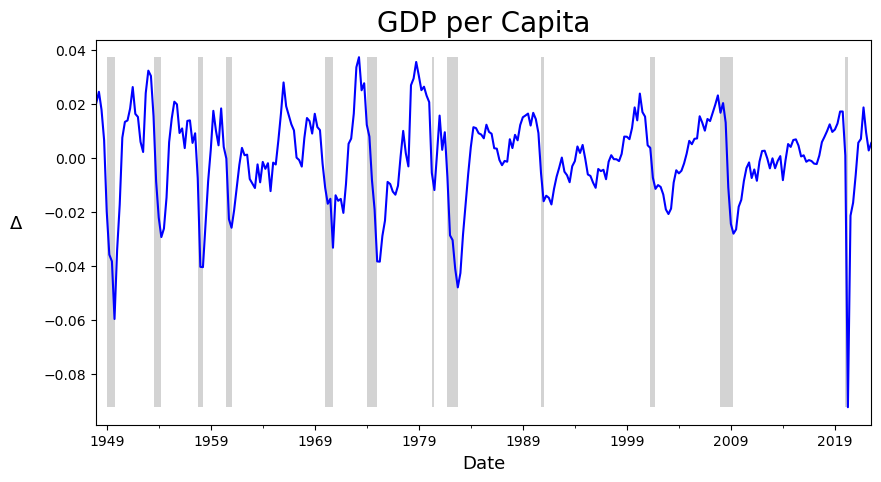

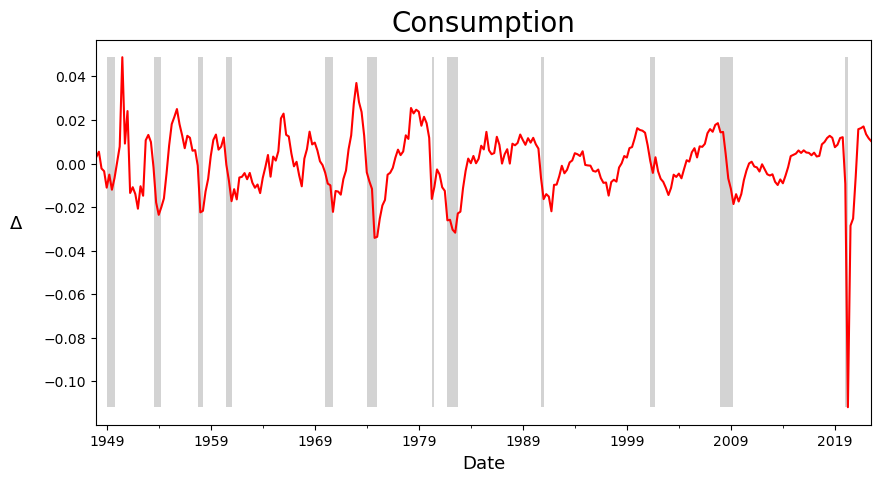

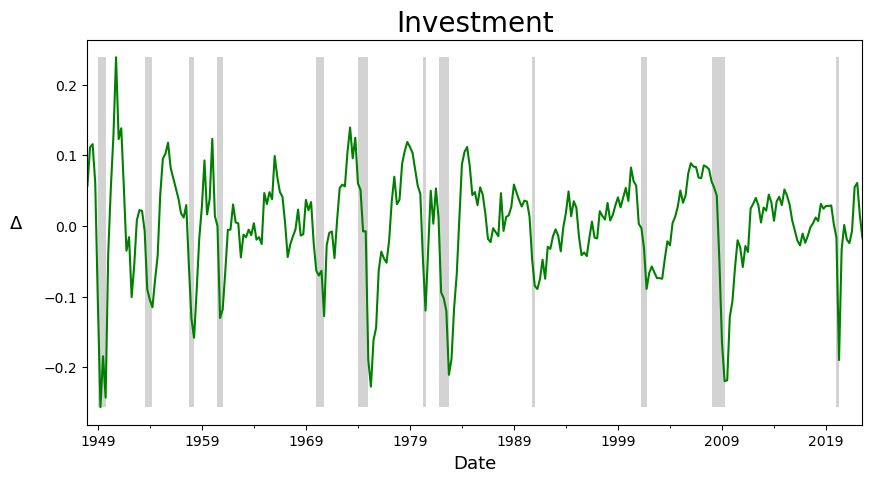

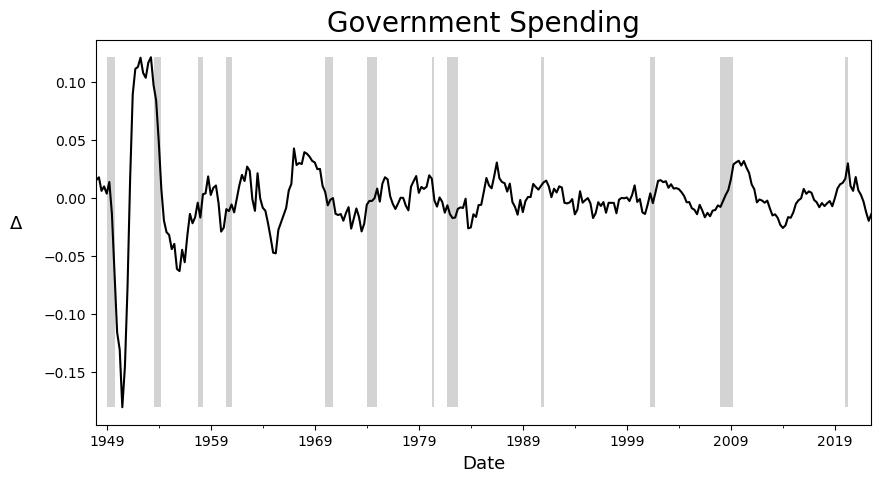

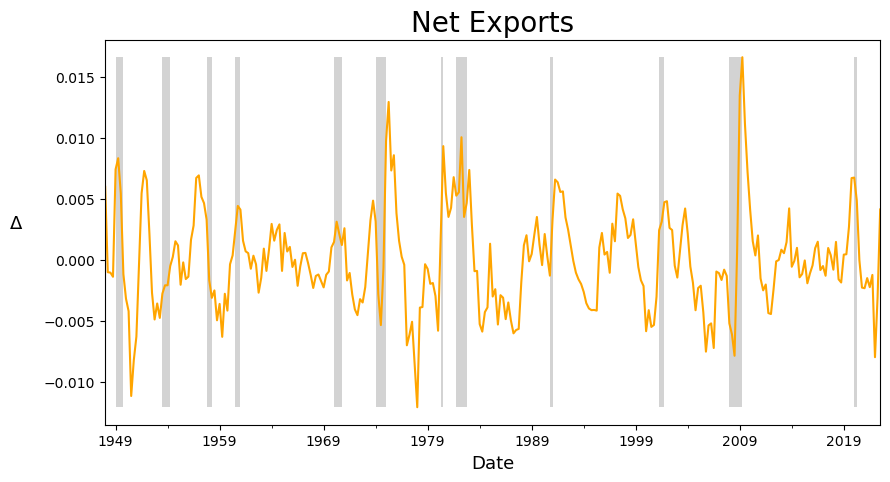

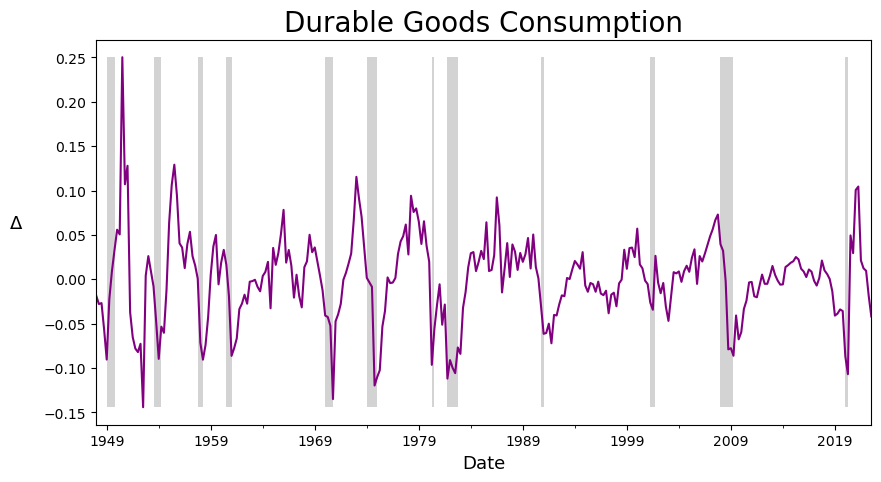

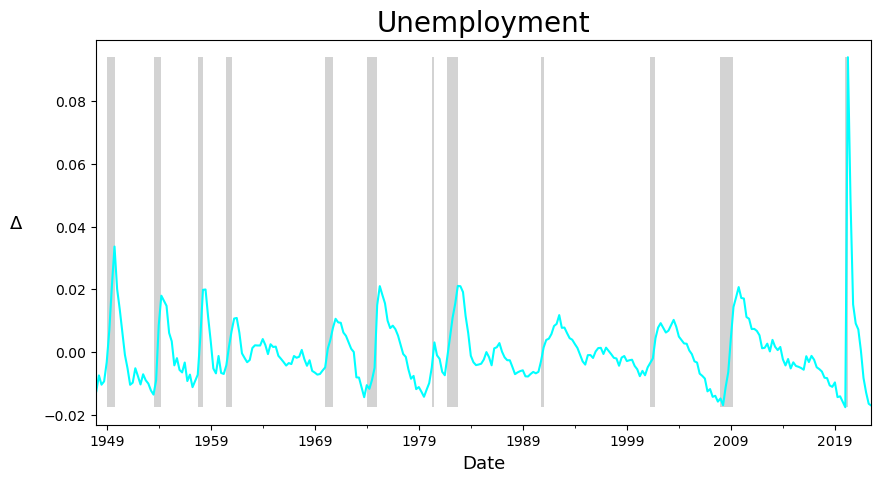

In [20]:
var = [Y_cycle, C_cycle, I_cycle, G_cycle, X_cycle, D_cycle, U_cycle]
vartitles = ['GDP per Capita', 'Consumption', 'Investment', 'Government Spending', 'Net Exports', 'Durable Goods Consumption', 
              "Unemployment"]
color = ['blue', 'red', 'green', 'black', 'orange', 'purple', 'cyan']

#Create recession plots
for (v,t,c) in zip(var, vartitles, color):
    fig, ax = plt.subplots()
    v.plot.line(ax=ax, x=v.index, color=c)
    ax.fill_between(v.index, min(v), max(v), where=(df_GDP['USRECQ'] == 1), alpha=0.5, facecolor='darkgrey')
    plt.title(t, fontsize=20)
    plt.xlabel('Date', fontsize=13)
    plt.ylabel('Δ', rotation='horizontal', labelpad=20, fontsize=13)
    plt.show()

## Creating Cross Correlation (vs Real GDP) Plots 

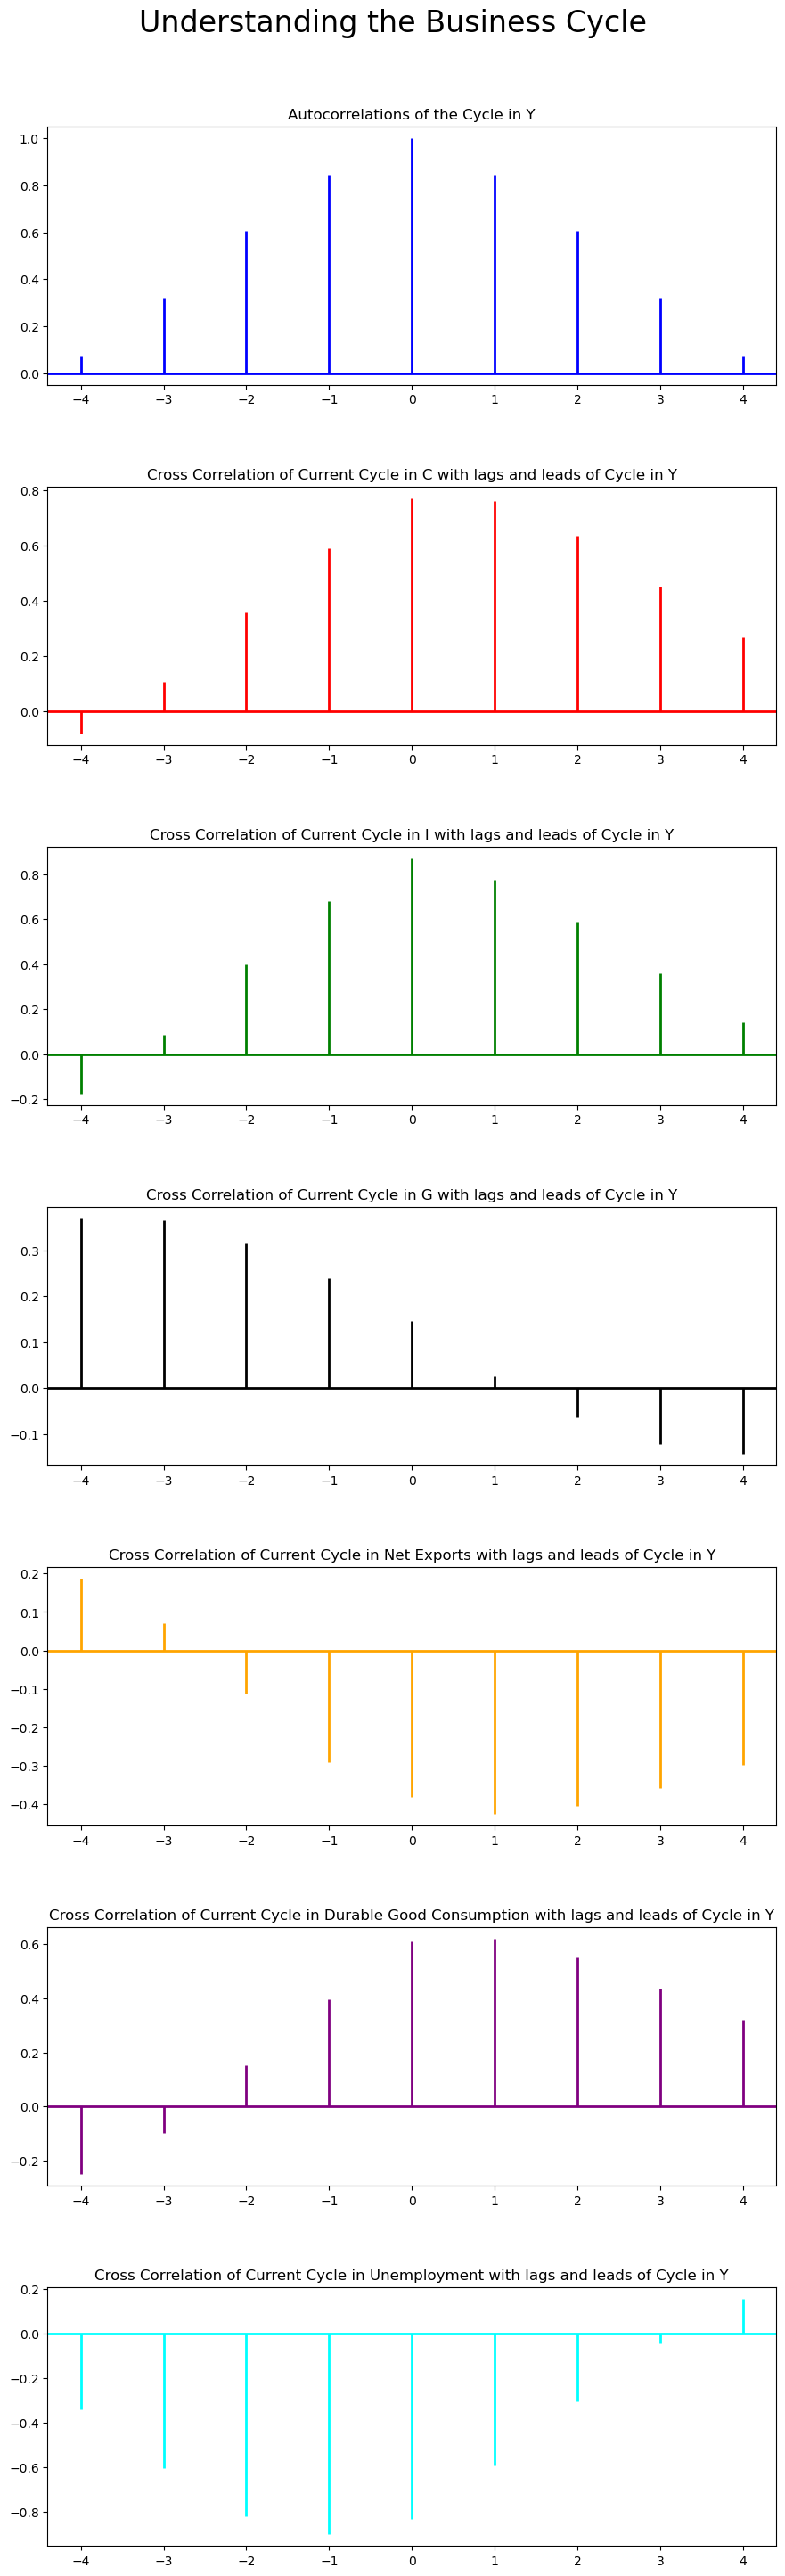

In [30]:
plt.rcParams['figure.figsize'] = (10,30)

fig, [ax1, ax2, ax3, ax4, ax5, ax6, ax7] = plt.subplots(7, 1, sharex=False)


fig.suptitle('Understanding the Business Cycle', fontsize=24)

ax1.acorr(Y_cycle, usevlines=True, normed=True, maxlags=4, lw=2, color = color[0])
ax1.set_title('Autocorrelations of the Cycle in Y')

ax2.set_title('Cross Correlation of Current Cycle in C with lags and leads of Cycle in Y')
ax2.xcorr(Y_cycle, C_cycle, usevlines=True, maxlags=4, normed=True, lw=2, color = color[1])

ax3.set_title('Cross Correlation of Current Cycle in I with lags and leads of Cycle in Y')
ax3.xcorr(Y_cycle, I_cycle, usevlines=True, maxlags=4, normed=True, lw=2, color = color[2])

ax4.set_title('Cross Correlation of Current Cycle in G with lags and leads of Cycle in Y')
ax4.xcorr(Y_cycle, G_cycle, usevlines=True, maxlags=4, normed=True, lw=2, color = color[3])

ax5.set_title('Cross Correlation of Current Cycle in Net Exports with lags and leads of Cycle in Y')
ax5.xcorr(Y_cycle, X_cycle, usevlines=True, maxlags=4, normed=True, lw=2, color = color[4])

ax6.set_title('Cross Correlation of Current Cycle in Durable Good Consumption with lags and leads of Cycle in Y')
ax6.xcorr(Y_cycle, D_cycle, usevlines=True, maxlags=4, normed=True, lw=2, color = color[5])

ax7.set_title('Cross Correlation of Current Cycle in Unemployment with lags and leads of Cycle in Y')
ax7.xcorr(Y_cycle, U_cycle, usevlines=True, maxlags=4, normed=True, lw=2, color = color[6])

fig.tight_layout(pad=5.0)
plt.show()

## Function to Create and Format Cross Correlation Tables

In [37]:
def maketable():
    table1 = []

    for x in var:
        backwards = sm.tsa.stattools.ccf(Y_cycle, x, adjusted=True)[0:5]
        forwards = sm.tsa.stattools.ccf(x, Y_cycle, adjusted=True)[1:5]
        ccf_output = np.concatenate((forwards[::-1], backwards))
        row = ccf_output.tolist()
        row.insert(0, statistics.stdev(x))
        table1.append(row.copy())
    
    df = pd.DataFrame(table1, columns = ['Standard Deviation', 'x(t-4)', 'x(t-3)', 'x(t-2)]', 'x(t-1)', 'x(t)', 
                                          'x(t+1)', 'x(t+2)', 'x(t+3)','x(t+4)'], index = vartitles)
    df.index.name = 'Variable'

    def style_negative(v, neg='', pos=''):
        if v < 0: 
            return neg 
        if v > 0: 
            return pos 

    def highlight_max(s, pmax=''):
        return np.where(s == np.nanmax(s.values), pmax, '')
    
    def highlight_min(s, pmin=''):
        return np.where(s == np.nanmin(s.values), pmin, '')
        
    subset = ['x(t-4)', 'x(t-3)', 'x(t-2)]', 'x(t-1)', 'x(t)', 'x(t+1)', 'x(t+2)', 'x(t+3)','x(t+4)']

    return df, df.style.format(precision=3).applymap(
        style_negative, neg='color:red;', pos='color:green;', subset=pd.IndexSlice[:, subset]).apply(
        highlight_max, pmax='color:white;background-color:green', axis=1, subset=pd.IndexSlice[:, subset]).apply(
        highlight_min, pmin='color:white;background-color:red', axis=1, subset=pd.IndexSlice[:, subset])

## Formatted Table for All Years (1948 - Q3:2022)
Note: May need to rerun notebook for formatting to appear.

In [38]:
end = datetime.datetime(2022, 7, 1)
df_GDP = importmacroA3(start, end)

Y_cycle, Y_trend = sm.tsa.filters.hpfilter(np.log(df_GDP['GDPC1']), 1600)
C_cycle, C_trend = sm.tsa.filters.hpfilter(np.log(df_GDP['PCECC96']), 1600)
I_cycle, I_trend = sm.tsa.filters.hpfilter(np.log(df_GDP['GPDIC1']), 1600)
G_cycle, G_trend = sm.tsa.filters.hpfilter(np.log(df_GDP['GCEC1']), 1600)
X_cycle, X_trend = sm.tsa.filters.hpfilter(df_GDP['Net Exports'], 1600)
D_cycle, D_trend = sm.tsa.filters.hpfilter(np.log(df_GDP['Durables']), 1600)
U_cycle, U_trend = sm.tsa.filters.hpfilter(df_GDP['Unemployment'], 1600)

var = [Y_cycle, C_cycle, I_cycle, G_cycle, X_cycle, D_cycle, U_cycle]

df1, df1format = maketable()
df1format

,Standard Deviation,x(t-4),x(t-3),x(t-2)],x(t-1),x(t),x(t+1),x(t+2),x(t+3),x(t+4)
Variable,,,,,,,,,,
GDP per Capita,0.017,0.049,0.279,0.543,0.781,1.000,0.781,0.543,0.279,0.049
Consumption,0.014,-0.111,0.068,0.306,0.534,0.797,0.680,0.539,0.365,0.197
Investment,0.072,-0.137,0.102,0.378,0.643,0.853,0.733,0.563,0.343,0.141
Government Spending,0.031,0.325,0.308,0.264,0.192,0.096,-0.009,-0.089,-0.142,-0.156
Net Exports,0.004,0.180,0.079,-0.089,-0.263,-0.367,-0.432,-0.426,-0.369,-0.302
Durable Goods Consumption,0.048,-0.261,-0.138,0.101,0.321,0.580,0.602,0.538,0.439,0.329
Unemployment,0.010,-0.242,-0.435,-0.615,-0.761,-0.805,-0.470,-0.244,-0.030,0.136


## Formatted Table that Omits Years After 2010 (1948-2010) 
Note: May need to rerun notebook for formatting to appear.

In [39]:
end2 = datetime.datetime(2010, 10, 1)
df_GDP2 = importmacroA3(start, end2)

Y_cycle, Y_trend = sm.tsa.filters.hpfilter(np.log(df_GDP2['GDPC1']), 1600)
C_cycle, C_trend = sm.tsa.filters.hpfilter(np.log(df_GDP2['PCECC96']), 1600)
I_cycle, I_trend = sm.tsa.filters.hpfilter(np.log(df_GDP2['GPDIC1']), 1600)
G_cycle, G_trend = sm.tsa.filters.hpfilter(np.log(df_GDP2['GCEC1']), 1600)
X_cycle, X_trend = sm.tsa.filters.hpfilter(df_GDP2['Net Exports'], 1600)
D_cycle, D_trend = sm.tsa.filters.hpfilter(np.log(df_GDP2['Durables']), 1600)
U_cycle, U_trend = sm.tsa.filters.hpfilter(df_GDP2['Unemployment'], 1600)

var = [Y_cycle, C_cycle, I_cycle, G_cycle, X_cycle, D_cycle, U_cycle]

df2, df2format = maketable()
df2format

,Standard Deviation,x(t-4),x(t-3),x(t-2)],x(t-1),x(t),x(t+1),x(t+2),x(t+3),x(t+4)
Variable,,,,,,,,,,
GDP per Capita,0.017,0.076,0.327,0.609,0.849,1.000,0.849,0.609,0.327,0.076
Consumption,0.013,-0.081,0.107,0.359,0.593,0.770,0.762,0.638,0.455,0.273
Investment,0.075,-0.178,0.089,0.401,0.682,0.870,0.776,0.594,0.363,0.145
Government Spending,0.033,0.376,0.369,0.318,0.241,0.147,0.026,-0.064,-0.124,-0.146
Net Exports,0.004,0.190,0.071,-0.114,-0.291,-0.382,-0.427,-0.408,-0.361,-0.302
Durable Goods Consumption,0.050,-0.254,-0.100,0.154,0.398,0.612,0.624,0.556,0.441,0.324
Unemployment,0.008,-0.347,-0.613,-0.828,-0.906,-0.834,-0.595,-0.307,-0.045,0.160


## Maximum Absolute Differences Between Tables

In [36]:
#replicate table from assignment
#NOTE: Minor differences in values are due to differences between the statstools ccf() and pandas corr() function

difference = abs(df1-df2)
difference.max(axis=1)

Variable
GDP per Capita               0.068062
Consumption                  0.099742
Investment                   0.043175
Government Spending          0.061663
Net Exports                  0.028878
Durable Goods Consumption    0.077645
Unemployment                 0.212744
dtype: float64

## Conclusions

All variables seem to show a cyclical relationship alongside real GDP. As shown by the cross-correlation plots, the cycles seem to return to stability (0% change) after 4 quarters of their peak.    

- Consumption seems to follow the Cycle of GDP. Consumption at time t is highly correlated with GPD at time t. Similarly, investment at time t is also highly correlated with the cycle of GDP at time t. Both variable are positively correlated with GDP, so when real GDP is booming both Consumption and Investment are also booming.  

- Government spending is positively correlated with past changes in GDP. So when GDP booms, future Government spending increases. This is intuitive because government spending is primarily dependant on tax revenue. So a boom in the economy will lead to higher tax revenue which allows for greater government spending.  

- Net Exports is negatively correlated with current GDP, and troughs with a lead of one quarter. So when GDP is booming, Net Exports falls. Net exports is $Exports - Imports$. This means that when the economy booms, there is either less exporting or more importing. Likely both. This 

- Durable goods consumption is positively correlated with booms in GDP and peaks with a one quarter leap in GDP. So when Durable Good consumption peaks, it is likely that the economy will boom in the next quarter. 

- Unemployment is negatively correlated with booms in GDP and the trough is in the same quarter. So when the economy peaks, unemployment is expected to be at it's lowest. 

These statistics seem to be quite stable. When ommiting the past decade, the same correlation patterns remain.

- Notable difference: when omitting the last decade, unemployment is no longer at it's lowest when the economy is booming. Instead unemployment is at it's lowest when the previous quarter was the GDP peak.

- This can also be shown by the maximum differences: All statistics apart from Unemployment have differences below 0.1, whereas Unemployment's maximum difference when omitting the last decade is above 0.2. 

In [42]:
end3 = datetime.datetime(2018, 10, 1)
df_GDP3 = importmacroA3(start, end3)

Y_cycle, Y_trend = sm.tsa.filters.hpfilter(np.log(df_GDP3['GDPC1']), 1600)
C_cycle, C_trend = sm.tsa.filters.hpfilter(np.log(df_GDP3['PCECC96']), 1600)
I_cycle, I_trend = sm.tsa.filters.hpfilter(np.log(df_GDP3['GPDIC1']), 1600)
G_cycle, G_trend = sm.tsa.filters.hpfilter(np.log(df_GDP3['GCEC1']), 1600)
X_cycle, X_trend = sm.tsa.filters.hpfilter(df_GDP3['Net Exports'], 1600)
D_cycle, D_trend = sm.tsa.filters.hpfilter(np.log(df_GDP3['Durables']), 1600)
U_cycle, U_trend = sm.tsa.filters.hpfilter(df_GDP3['Unemployment'], 1600)

var = [Y_cycle, C_cycle, I_cycle, G_cycle, X_cycle, D_cycle, U_cycle]

df3, df3format = maketable()
df3format

,Standard Deviation,x(t-4),x(t-3),x(t-2)],x(t-1),x(t),x(t+1),x(t+2),x(t+3),x(t+4)
Variable,,,,,,,,,,
GDP per Capita,0.016,0.087,0.334,0.612,0.849,1.000,0.849,0.612,0.334,0.087
Consumption,0.012,-0.068,0.117,0.365,0.596,0.769,0.759,0.637,0.456,0.276
Investment,0.073,-0.146,0.114,0.415,0.684,0.867,0.775,0.599,0.377,0.166
Government Spending,0.032,0.347,0.339,0.289,0.216,0.125,0.006,-0.083,-0.142,-0.161
Net Exports,0.004,0.173,0.056,-0.127,-0.299,-0.385,-0.432,-0.415,-0.370,-0.313
Durable Goods Consumption,0.048,-0.230,-0.077,0.171,0.409,0.618,0.630,0.562,0.448,0.333
Unemployment,0.008,-0.366,-0.618,-0.821,-0.892,-0.822,-0.596,-0.322,-0.071,0.126


In [45]:
difference2 = abs(df2-df3)
difference2.max(axis=1)

Variable
GDP per Capita               0.010831
Consumption                  0.013127
Investment                   0.032002
Government Spending          0.029954
Net Exports                  0.016624
Durable Goods Consumption    0.024552
Unemployment                 0.034503
dtype: float64

- Above compares the analysis that omits the last decade to one that only omits the last 4-5 years (the COVID recession). The absolute difference in unemployment now disappears. This means that whatever has cause the change in the nature of unemployment in the last decade or so likely happened before COVID.